In [1]:
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

from qiskit.visualization import plot_histogram

In [2]:
n = 3 # length of n-bit string

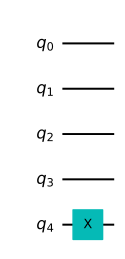

In [42]:
# Constant Oracle
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
const_oracle.draw()

## 자주 쓰이는 테크닉
- 그냥 애초에 게이트를 설치할 장소를 string으로 만들어놓고, for문으로 설치하도록 함.

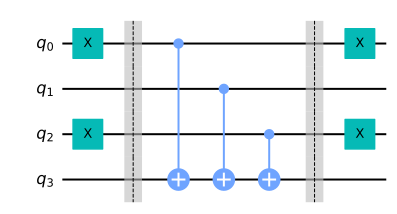

In [6]:
# Balanced Oracle
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

C:\Users\pmang\AppData\Local\Temp/ipykernel_19384/460382824.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


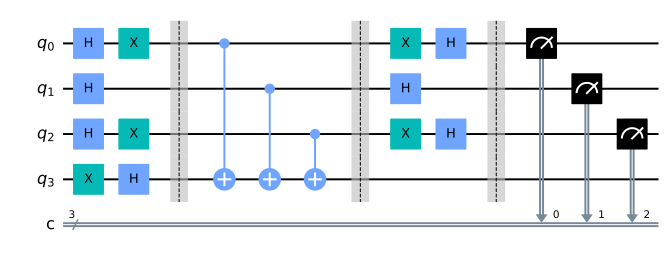

In [7]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

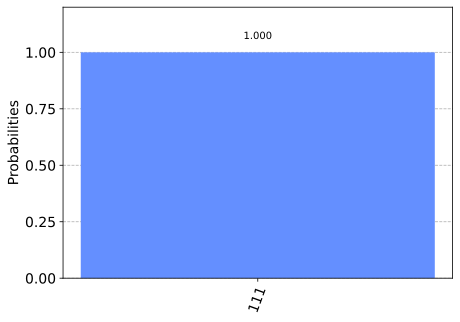

In [8]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [10]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if case == 'balanced':
        b = np.random.randint(1, 2**n)
        # 변수 b를 str(n)자리 수의 이진수('b')로 포매팅 시켜서 스트링으로 반환
        b_str = format(b, '0'+str(n)+'b')
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
                    
    if case == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
            
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name= 'Oracle'
    return oracle_gate

In [11]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    dj_circuit.append(oracle, range(n+1))
    
    for qubit in range(n):
        dj_circuit.h(qubit)
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

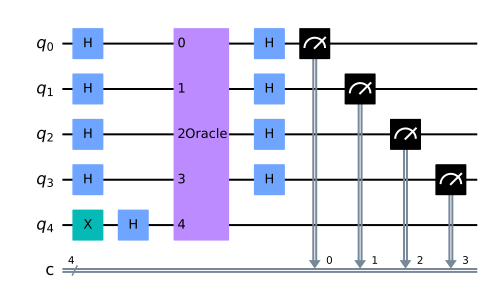

In [12]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

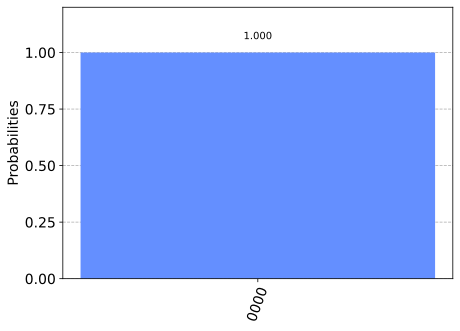

In [13]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [23]:
IBMQ.save_account('527bb796d10dccf83bef5c63447919fcef3d3c176a6092f43fecbf204aefa9c3158d09e612471b45d4538d7f131dd165d181b50d0726aa496a17175a4efc86c1', overwrite=True)

In [25]:
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-07-21 00:35:09,224: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem


In [39]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


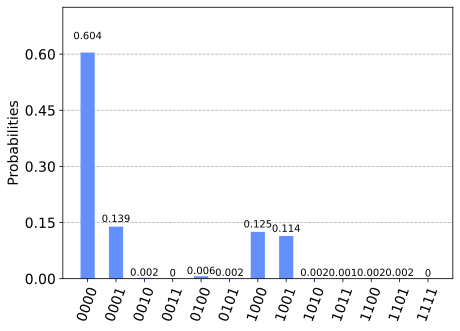

In [40]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [38]:
b = np.random.randint(1,2**n)
b_str = format(b, '0'+str(n)+'b')
print('0'+str(n)+'b')
print(b_str)

04b
1000
